Once more, I'm trying to show a play-by-play analysis of the Israeli GTFS, with [hasadna/open-bus](https://github.com/hasadna/open-bus) interests in mind.

This post is more of a data cleanup diary log. While working on some stuff I found issues with the dataset I was working with, I thought it would be good to document this, and show the process of finding these issues, and how some simple analysis (AKA debugging) helped finding the source of these symptoms and a cure.

The agenda:
1. [Get up-to-date GTFS files from the MOT FTP server](#Get-the-data)
2. [Merge and tidy](#Tidy-it-up)
3. [Cleanup Diary](#Cleanup-Diary)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

sns.set(style="whitegrid")
sns.set_context("talk")

## Get the data
We get the data straight from MOT's ftp. Just so I don't repeat the last post, this went out to a separate module.

In [3]:
from gtfs_utils import *

conn = ftp_connect()
ftp_dir = get_ftp_dir(conn)
UPTODATE = 90 #days
our_uptodateness = get_uptodateness(ftp_dir)

if our_uptodateness > UPTODATE:
    get_ftp_file(conn)
    get_ftp_file(conn, file_name = 'Tariff.zip', local_zip_path = 'data/sample/tariff.zip' )

conn.quit()

'221 Goodbye.'

We load MOT's tarrif.txt file, which will give us zone names and other local info.
Found out it's the file is even more fd-up than I realized, so I add the southern zones manualy

In [4]:
tariff_df = extract_tariff_df(local_zip_path = 'data/sample/tariff.zip')
south = [
    {
        'zone_name': 'מצפה רמון',
        'zone_id': '903'
    },
    {
        'zone_name': 'ערבה',
        'zone_id': '902'
    },
    {
        'zone_name': 'אילת',
        'zone_id': '901'
    },]
south = pd.DataFrame(south)
tariff_df = tariff_df.append(south)
tariff_df

,Daily,FromDate,Monthly,ShareCode,ToDate,Weekly,zone_id,zone_name
0,13.5,01/04/2016 00:00:00,213.0,141.0,01/01/2200 00:00:00,64.0,210,גוש דן
10,13.5,01/04/2016 00:00:00,149.0,152.0,01/01/2200 00:00:00,57.5,221,שרון
11,13.5,01/04/2016 00:00:00,149.0,153.0,01/01/2200 00:00:00,57.5,222,ראש העין שוהם
12,13.5,01/04/2016 00:00:00,149.0,154.0,01/01/2200 00:00:00,57.5,223,רחובות
13,13.5,01/04/2016 00:00:00,149.0,155.0,01/01/2200 00:00:00,57.5,231,נתניה
14,13.5,01/04/2016 00:00:00,149.0,156.0,01/01/2200 00:00:00,57.5,232,חבל מודיעין
15,13.5,01/04/2016 00:00:00,149.0,157.0,01/01/2200 00:00:00,57.5,233,אשדוד
16,9.5,01/04/2016 00:00:00,149.0,171.0,01/01/2200 00:00:00,42.5,410,באר שבע
24,13.5,01/04/2016 00:00:00,136.0,180.0,01/01/2200 00:00:00,39.5,421,רהט להבים
25,13.5,01/04/2016 00:00:00,136.0,181.0,01/01/2200 00:00:00,39.5,422,אופקים


## Tidy it up
Again I'm using [partridge](https://github.com/remix/partridge/tree/master/partridge) for filtering on dates, and then some tidying up and transformations.

In [37]:
LOCAL_ZIP_PATH = 'data/sample/gtfs.zip' 

import partridge as ptg

service_ids_by_date = ptg.read_service_ids_by_date(LOCAL_ZIP_PATH)
service_ids = service_ids_by_date[datetime.date(2017, 12, 21)]

feed = ptg.feed(LOCAL_ZIP_PATH, view={
    'trips.txt': {
        'service_id': service_ids,
    },
})

In [38]:
def to_timedelta(df):
    '''
    Turn time columns into timedelta dtype
    '''
    cols = ['arrival_time', 'departure_time']
    numeric = df[cols].apply(pd.to_timedelta, unit='s')
    df = df.copy()
    df[cols] = numeric
    return df

In [39]:
s = feed.stops
r = feed.routes
t = (feed.trips
     .assign(route_id=lambda x: pd.Categorical(x['route_id'])))

In [40]:
f = (feed.stop_times[['trip_id', 'departure_time', 'arrival_time', 'stop_id', 'stop_sequence']]
     .assign(date = datetime.date(2017, 12, 21))
     .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'zone_id']], on='stop_id')
     # Much faster joins and slices with Categorical dtypes
     .merge(tariff_df[['zone_id', 'zone_name']], on='zone_id')
     .assign(zone_id=lambda x: pd.Categorical(x['zone_id']))
     .assign(zone_name=lambda x: pd.Categorical(x['zone_name']))
     .merge(t[['trip_id', 'route_id', 'direction_id']], on='trip_id')
     .merge(r[['route_id', 'route_short_name', 'route_long_name']], on='route_id')
     .assign(route_id=lambda x: pd.Categorical(x['route_id']))
     .pipe(to_timedelta)
    )
f.head()

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,date,stop_name,stop_lat,stop_lon,zone_id,zone_name,route_id,direction_id,route_short_name,route_long_name
0,28917380_191217,08:57:00,08:57:00,37312,1,2017-12-21,באר שבע מרכז,31.242886,34.798546,410,באר שבע,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
1,28917380_191217,09:04:00,09:04:00,37314,2,2017-12-21,באר שבע-צפון,31.262089,34.809287,410,באר שבע,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
2,28917380_191217,09:13:00,09:13:00,37308,3,2017-12-21,להבים רהט,31.369907,34.798040,421,רהט להבים,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
3,28917380_191217,09:29:00,09:29:00,37316,4,2017-12-21,קרית גת,31.603526,34.777955,802,קריית גת,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
4,28917380_191217,09:54:00,09:54:00,37336,5,2017-12-21,רמלה,31.928809,34.877304,210,גוש דן,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו


## Cleanup Diary
That's what I was first trying to answer. This is an important parameter we have to be familiar with - trip final stops. Our current best polling strategy sends requests on these stops only.

#### One (wrong) way
So it actually started when I was trying to find simple loop lines (A --> A). I (naively) thought to myself, lets get the first and last stop for all trips.

I did it like so - 

In [34]:
import pickle
import os

In [35]:
# using a custom groupby aggregation function, this is VERY inefficient,
# but far more readable than doing some other magic, so I'm sticking to it for now

def apply_and_pickle(f, pkl_path, apply_func):
    if not os.path.exists(pkl_path):
        ret_df = f.groupby('trip_id').apply(apply_func)
        # since it's so inefficient I pickle it
        with open(pkl_path, 'wb') as pkl_file:
            pickle.dump(orig_dest_only, pkl_file)
    else:
        with open(pkl_path, 'rb') as pkl_file:
            ret_df = pickle.load(pkl_file)
        return ret_df

def first_last(df):
    return df.sort_values(by='stop_sequence').iloc[[0, -1]]

orig_dest_only = apply_and_pickle(f, 'softloop.pkl', first_last)

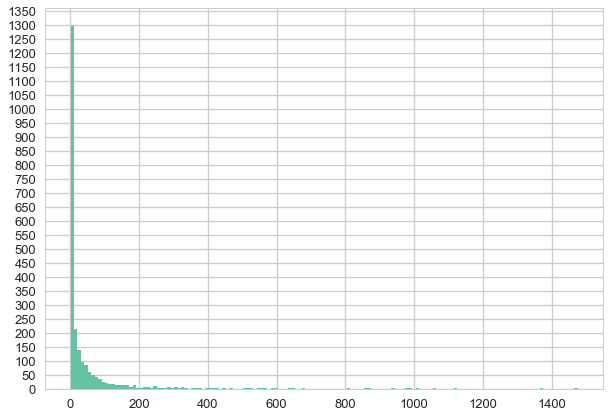

In [67]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_yticks(np.arange(32)*50)
orig_dest_only[orig_dest_only.stop_sequence!=1].groupby('stop_id').size().sort_values(ascending=False).hist(bins=147, ax=ax)

I was all jolly and happy, until I did this:

In [23]:
orig_dest_only[orig_dest_only.stop_sequence!=1].groupby('stop_id').size().sum()

92384

In [55]:
t.shape

(89777, 6)

No good. I've actually found more last stops than trips...

This could be due to a gazillion reasons, so lets go ahead and go over them until we nail it.

#### stop_sequence Mystery or "The Bus with No Origin"
I used stop_sequence to find first and last stops, maybe there's an issue in the data

Let's just do a simple count - 

In [41]:
f[f.stop_sequence==1].shape

(89105, 15)

In [42]:
f[f.stop_sequence==2].shape

(91314, 15)

There's less first stop than trips, but more 2nd stops than trips. Ok this is crazy, and certainly needs to be looked at in the future, but lets just leave it and use some other field for this task.

TODO: dig into stop_sequence and talk to MOT about this


#### Better yet - timing is everything
So lets use the `arrival_time` field instead, which should be cleaner. I'll skip the inefficient method I used before with the custom groupby aggregationm, and go for some neat trick using the mighty `transform` method.

In [43]:
idx = f.groupby(['trip_id'], sort=False)['departure_time'].transform(max) == f['departure_time']
f[idx].sort_values(by='trip_id')

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,date,stop_name,stop_lat,stop_lon,zone_id,zone_name,route_id,direction_id,route_short_name,route_long_name
3226900,10096398_171217,0 days 22:05:22,0 days 22:05:22,34503,37,2017-12-21,אוניברסיטת אריאל/כביש 31,32.105926,35.210692,234,השומרון,9735,1,70,קניון קרני שומרון-קרני שומרון<->אוניברסיטת ארי...
3226937,10096399_171217,1 days 00:05:22,1 days 00:05:22,34503,37,2017-12-21,אוניברסיטת אריאל/כביש 31,32.105926,35.210692,234,השומרון,9735,1,70,קניון קרני שומרון-קרני שומרון<->אוניברסיטת ארי...
3227555,10221383_171217,0 days 15:21:28,0 days 15:21:28,34654,16,2017-12-21,קופת חולים לאומית/דרך הנחשונים,32.105873,35.171849,234,השומרון,9194,1,102,קופת חולים כללית-ברכה<->קופת חולים לאומית/דרך ...
3227571,10221384_171217,0 days 16:26:28,0 days 16:26:28,34654,16,2017-12-21,קופת חולים לאומית/דרך הנחשונים,32.105873,35.171849,234,השומרון,9194,1,102,קופת חולים כללית-ברכה<->קופת חולים לאומית/דרך ...
973521,10230038_171217,0 days 16:26:40,0 days 16:26:40,22173,31,2017-12-21,בריכה/עמק דותן,31.899377,35.017810,232,חבל מודיעין,11169,1,101,מסוף 2000-תל אביב יפו<->בריכה/עמק דותן-מודיעין...
973520,10230038_171217,0 days 16:26:40,0 days 16:26:40,22173,31,2017-12-21,בריכה/עמק דותן,31.899377,35.017810,232,חבל מודיעין,11169,1,101,מסוף 2000-תל אביב יפו<->בריכה/עמק דותן-מודיעין...
560116,10232240_171217,0 days 15:40:38,0 days 15:40:38,24713,18,2017-12-21,תחנת רכבת מרכז,31.900996,35.005017,232,חבל מודיעין,11200,1,112,מסוף 2000-תל אביב יפו<->תחנה מרכזית/הורדה-מודי...
560117,10232240_171217,0 days 15:40:38,0 days 15:40:38,24713,18,2017-12-21,תחנת רכבת מרכז,31.900996,35.005017,232,חבל מודיעין,11200,1,112,מסוף 2000-תל אביב יפו<->תחנה מרכזית/הורדה-מודי...
560143,10232241_171217,0 days 15:55:38,0 days 15:55:38,24713,18,2017-12-21,תחנת רכבת מרכז,31.900996,35.005017,232,חבל מודיעין,11200,1,112,מסוף 2000-תל אביב יפו<->תחנה מרכזית/הורדה-מודי...
560142,10232241_171217,0 days 15:55:38,0 days 15:55:38,24713,18,2017-12-21,תחנת רכבת מרכז,31.900996,35.005017,232,חבל מודיעין,11200,1,112,מסוף 2000-תל אביב יפו<->תחנה מרכזית/הורדה-מודי...


That took less than a second to run, now lets see if we also got better results

In [44]:
f[idx].shape

(92212, 15)

Ok we're on the good side of the error this time (I think), with some false positives instead of negatives.

But now it means we might have duplicate trips in our dataset :(

Let's zoom-in on one of the duplicate trips

In [49]:
f[idx].trip_id.value_counts().head()

24167955_171217    2
24026560_211217    2
24474733_211217    2
30282177_211217    2
24024130_211217    2
Name: trip_id, dtype: int64

In [50]:
st = feed.stop_times
st[((st.trip_id=='24167955_171217') & (st.stop_sequence==31)) ]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled
14876171,24167955_171217,56920.0,56920.0,36923,31,0.0,0,6364


In [51]:
f[((f.trip_id=='24167955_171217') & (f.stop_sequence==31)) ]

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,date,stop_name,stop_lat,stop_lon,zone_id,zone_name,route_id,direction_id,route_short_name,route_long_name
2757683,24167955_171217,15:48:40,15:48:40,36923,31,2017-12-21,הריטב''א ג,31.929852,35.049796,232,חבל מודיעין,11514,1,5,מסילת ישרים/דרך קרית ספר-מודיעין עילית<->אבי ע...
2757684,24167955_171217,15:48:40,15:48:40,36923,31,2017-12-21,הריטב''א ג,31.929852,35.049796,232,חבל מודיעין,11514,1,5,מסילת ישרים/דרך קרית ספר-מודיעין עילית<->אבי ע...


Ok, that looks better, this problem is only in my `f` feed merged data frame, not in the original `stop_times.txt`.

I debug `f`'s creation to see (by building it one step at a time), I spare you these steps, and give you the problematic step: 

In [52]:
ftest = (feed.stop_times[['trip_id', 'departure_time', 'arrival_time', 'stop_id', 'stop_sequence']]
     .assign(date = datetime.date(2017, 12, 21))
     .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'zone_id']], on='stop_id')
      # Much faster joins and slices with Categorical dtypes
     .merge(tariff_df[['zone_id', 'zone_name']], on='zone_id')

    )
ftest[ ((ftest.trip_id=='10230038_171217') & (ftest.stop_sequence==31)) ]

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,date,stop_name,stop_lat,stop_lon,zone_id,zone_name
2557765,10230038_171217,59200.0,59200.0,22173,31,2017-12-21,בריכה/עמק דותן,31.899377,35.01781,232,חבל מודיעין
2557766,10230038_171217,59200.0,59200.0,22173,31,2017-12-21,בריכה/עמק דותן,31.899377,35.01781,232,חבל מודיעין


In [37]:
tariff_df[tariff_df.zone_id=='232']

,Daily,FromDate,Monthly,ShareCode,ToDate,Weekly,zone_id,zone_name
14,13.5,01/04/2016 00:00:00,149.0,156.0,01/01/2200 00:00:00,57.5,232,חבל מודיעין
57,13.5,01/04/2016 00:00:00,149.0,697.0,01/01/2200 00:00:00,57.5,232,חבל מודיעין


Got it! Source of all evil - the super-messy tariff file where we get the zone names from.

In [47]:
tariff_df.groupby(['zone_id', 'zone_name']).size()

zone_id  zone_name                
110      סובב ירושלים                 1
121      הרי ירושלים                  1
122      בנימין                       1
123      גוש עציון                    1
131      אזור בית שמש                 1
133      בקעת ים המלח                 1
134      אזור קריית ארבע              1
135      גוש שילה ובקעה               1
210      גוש דן                       1
221      שרון                         1
222      ראש העין שוהם                1
223      רחובות                       1
231      נתניה                        1
232      חבל מודיעין                  2
233      אשדוד                        1
234      השומרון                      1
310      סובב חיפה                    1
321      עכו                          1
322      יוקנעם- טבעון                1
331      נהריה                        1
332      כרמיאל                       1
333      נצרת                         1
334      זכרון                        1
410      באר שבע                      1
421  

See if you can find the needle...

Now lets rebuild our `f` dataset with deduped zones:

In [54]:
ftry = (feed.stop_times[['trip_id', 'departure_time', 'arrival_time', 'stop_id', 'stop_sequence']]
     .assign(date = datetime.date(2017, 12, 21))
     .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'zone_id']], on='stop_id')
      # Much faster joins and slices with Categorical dtypes
     .merge(tariff_df.groupby(['zone_id', 'zone_name']).size().reset_index()[['zone_id', 'zone_name']], on='zone_id')
    )
ftry [ ((ftry.trip_id=='10230038_171217') & (ftry.stop_sequence==31)) ]

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,date,stop_name,stop_lat,stop_lon,zone_id,zone_name
2493834,10230038_171217,59200.0,59200.0,22173,31,2017-12-21,בריכה/עמק דותן,31.899377,35.01781,232,חבל מודיעין


In [55]:
new_f = (feed.stop_times[['trip_id', 'departure_time', 'arrival_time', 'stop_id', 'stop_sequence']]
     .assign(date = datetime.date(2017, 12, 21))
     .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'zone_id']], on='stop_id')
     # Much faster joins and slices with Categorical dtypes
     .merge(tariff_df.groupby(['zone_id', 'zone_name']).size().reset_index()[['zone_id', 'zone_name']], on='zone_id')
     .assign(zone_id=lambda x: pd.Categorical(x['zone_id']))
     .assign(zone_name=lambda x: pd.Categorical(x['zone_name']))
     .merge(t[['trip_id', 'route_id', 'direction_id']], on='trip_id')
     .merge(r[['route_id', 'route_short_name', 'route_long_name']], on='route_id')
     .assign(route_id=lambda x: pd.Categorical(x['route_id']))
     .pipe(to_timedelta)
    )
new_f.head()

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,date,stop_name,stop_lat,stop_lon,zone_id,zone_name,route_id,direction_id,route_short_name,route_long_name
0,28917380_191217,08:57:00,08:57:00,37312,1,2017-12-21,באר שבע מרכז,31.242886,34.798546,410,באר שבע,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
1,28917380_191217,09:04:00,09:04:00,37314,2,2017-12-21,באר שבע-צפון,31.262089,34.809287,410,באר שבע,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
2,28917380_191217,09:13:00,09:13:00,37308,3,2017-12-21,להבים רהט,31.369907,34.798040,421,רהט להבים,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
3,28917380_191217,09:29:00,09:29:00,37316,4,2017-12-21,קרית גת,31.603526,34.777955,802,קריית גת,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
4,28917380_191217,09:54:00,09:54:00,37336,5,2017-12-21,רמלה,31.928809,34.877304,210,גוש דן,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו


TODO: apply this fix to previous and in-progress notebooks

In [56]:
idx = new_f.groupby(['trip_id'], sort=False)['arrival_time'].transform(max) == new_f['arrival_time']
new_f[idx].sort_values(by='trip_id')

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,date,stop_name,stop_lat,stop_lon,zone_id,zone_name,route_id,direction_id,route_short_name,route_long_name
3144684,10096398_171217,0 days 22:05:22,0 days 22:05:22,34503,37,2017-12-21,אוניברסיטת אריאל/כביש 31,32.105926,35.210692,234,השומרון,9735,1,70,קניון קרני שומרון-קרני שומרון<->אוניברסיטת ארי...
3144721,10096399_171217,1 days 00:05:22,1 days 00:05:22,34503,37,2017-12-21,אוניברסיטת אריאל/כביש 31,32.105926,35.210692,234,השומרון,9735,1,70,קניון קרני שומרון-קרני שומרון<->אוניברסיטת ארי...
3145339,10221383_171217,0 days 15:21:28,0 days 15:21:28,34654,16,2017-12-21,קופת חולים לאומית/דרך הנחשונים,32.105873,35.171849,234,השומרון,9194,1,102,קופת חולים כללית-ברכה<->קופת חולים לאומית/דרך ...
3145355,10221384_171217,0 days 16:26:28,0 days 16:26:28,34654,16,2017-12-21,קופת חולים לאומית/דרך הנחשונים,32.105873,35.171849,234,השומרון,9194,1,102,קופת חולים כללית-ברכה<->קופת חולים לאומית/דרך ...
966190,10230038_171217,0 days 16:26:40,0 days 16:26:40,22173,31,2017-12-21,בריכה/עמק דותן,31.899377,35.017810,232,חבל מודיעין,11169,1,101,מסוף 2000-תל אביב יפו<->בריכה/עמק דותן-מודיעין...
559439,10232240_171217,0 days 15:40:38,0 days 15:40:38,24713,18,2017-12-21,תחנת רכבת מרכז,31.900996,35.005017,232,חבל מודיעין,11200,1,112,מסוף 2000-תל אביב יפו<->תחנה מרכזית/הורדה-מודי...
559457,10232241_171217,0 days 15:55:38,0 days 15:55:38,24713,18,2017-12-21,תחנת רכבת מרכז,31.900996,35.005017,232,חבל מודיעין,11200,1,112,מסוף 2000-תל אביב יפו<->תחנה מרכזית/הורדה-מודי...
559475,10232242_171217,0 days 16:15:38,0 days 16:15:38,24713,18,2017-12-21,תחנת רכבת מרכז,31.900996,35.005017,232,חבל מודיעין,11200,1,112,מסוף 2000-תל אביב יפו<->תחנה מרכזית/הורדה-מודי...
559493,10232243_171217,0 days 16:25:38,0 days 16:25:38,24713,18,2017-12-21,תחנת רכבת מרכז,31.900996,35.005017,232,חבל מודיעין,11200,1,112,מסוף 2000-תל אביב יפו<->תחנה מרכזית/הורדה-מודי...
559511,10232244_171217,0 days 16:40:38,0 days 16:40:38,24713,18,2017-12-21,תחנת רכבת מרכז,31.900996,35.005017,232,חבל מודיעין,11200,1,112,מסוף 2000-תל אביב יפו<->תחנה מרכזית/הורדה-מודי...


In [57]:
new_f[idx].shape

(89768, 15)

now we're missing 9. hmmmm... 

Lets see which ones we're missing.

In [62]:
t = t.set_index('trip_id')

In [63]:
missing_trips = t[~t.index.isin(new_f.trip_id)]
missing_trips

,route_id,service_id,trip_headsign,direction_id,shape_id
trip_id,,,,,
30277345_211217,8630,54178129,מודיעין עילית _ מרכז,1,NaN
30277344_211217,8630,54178129,מודיעין עילית _ מרכז,1,NaN
30277772_211217,8647,54178161,NaN,1,NaN
30277770_211217,8647,54178161,NaN,1,NaN
30278247_211217,8664,54178172,מודיעין עילית _ אחוזת ברכפלד,1,NaN
30278261_211217,8664,54178172,מודיעין עילית _ אחוזת ברכפלד,1,NaN
30278540_211217,8678,54178210,בני ברק _ מרכז,0,NaN
30278718_211217,8681,54178238,מודיעין עילית _ נאות הפסגה,1,63594
30278717_211217,8681,54178238,מודיעין עילית _ נאות הפסגה,1,63594


Maybe they just don't have stop times?

In [64]:
st[st.trip_id.isin(missing_trips.index)]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled


Nope. Good!

To be safe lets test we are getting stop_times from the same line with different trips

In [65]:
test_trips = t.head()
test_trips

,route_id,service_id,trip_headsign,direction_id,shape_id
trip_id,,,,,
30179315_211217,20444,54163484,יהוד מונוסון _ דרך העצמאות,0,82704
30179316_211217,20444,54163484,יהוד מונוסון _ דרך העצמאות,0,82704
30180186_211217,20354,54163559,יהוד מונוסון _ דרך העצמאות,1,82455
30180187_211217,20354,54163559,יהוד מונוסון _ דרך העצמאות,1,82455
30180188_211217,20354,54163559,יהוד מונוסון _ דרך העצמאות,1,82455


In [66]:
st[st.trip_id.isin(test_trips.index)]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled
14618361,30179315_211217,3600.0,3600.0,13284,1,0.0,1,0
14618362,30179315_211217,3722.0,3722.0,14564,2,0.0,0,589
14618363,30179315_211217,3771.0,3771.0,13317,3,0.0,0,959
14618364,30179315_211217,3876.0,3876.0,12882,4,0.0,0,1353
14618365,30179315_211217,3988.0,3988.0,12896,5,0.0,0,1900
14618366,30179315_211217,4075.0,4075.0,13679,6,0.0,0,2335
14618367,30179315_211217,4178.0,4178.0,13127,7,0.0,0,2741
14618368,30179315_211217,4254.0,4254.0,12858,8,0.0,0,3173
14618369,30179315_211217,4308.0,4308.0,13634,9,0.0,0,3449
14618370,30179315_211217,4408.0,4408.0,14338,10,0.0,0,3816


Woohoo! looks like we're good to go. 

To shortly sum up - cleanup is an ongoing process. I have found an issue in the original data (stop_sequence) and an issue with how I merged tables (double zone in the very very messy tariffs table). 

See you soon when I test [GTFS best practices](http://gtfs.org/best-practices) on our GTFS files (with regards to loops routes, lasso routes and some more).